# Titanic Machine Learning Project

The goal of this project is to build a machine learning model that predicts which passengers survived the Titanic with the greatest possible accuracy.

Next Steps: Improve markdown; combine test and train and separate; 

## 1. Imports and Concatenation

### 1a. Imports and Reading the Data

In [1]:
import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, log_loss
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

In [2]:
train_df = pd.read_csv('Data/train.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_df = pd.read_csv('Data/test.csv')

In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


The data comes in two separate files; the test data does not include the survived category. To reduce redundancy with data cleaning and feature engineering, I concatenate the two dataframes together in the following section. I also create a function that allows me to separate them into two dataframes for modeling.

### 1b. Concatenating Train and Test

In [6]:
train_df_len = len(train_df)
test_df_len = len(test_df)

In [7]:
# This code to combine and separate the train and test DataFrames is adapted from the following YouTube video: 
# https://www.youtube.com/watch?v=Tm70lEXivCg&t=893s

def combine_df(train_df, test_df):
    combined_df = pd.concat([train_df, test_df], ignore_index=True)
    return combined_df

def separate_df(combined_df, train_df_len, test_df_len):
    train_df = combined_df.iloc[:train_df_len]
    test_df = combined_df.iloc[train_df_len:train_df_len + test_df_len]
    return train_df, test_df

full_df = combine_df(train_df, test_df)
len(full_df)

1309

With all of the data stored in a single dataframe, it is time for cleaning.

## 2. Data Cleaning

### 2a. Check for Nulls and Duplicates

In [8]:
full_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


Only 38% of passengers survived; the data is somewhat imbalanced but not severely so. This also provides a baseline accuracy score.

In [9]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [10]:
full_df.duplicated('PassengerId').sum()

0

Most of the columns contain no null values, and there are no duplicate records based on the passenger id. Cabin and age contain the most nulls; fare and embarked contain a few. I review each column with null values for cleaning.

### 2b. Cabin Null Values

In [11]:
full_df['Cabin'].value_counts()

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
F2                 4
D                  4
                  ..
E58                1
A20                1
D45                1
E17                1
C118               1
Name: Cabin, Length: 186, dtype: int64

In [12]:
full_df['Cabin'].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

Because each cabin is more or less unique to each individual, or at least shared with only a few others, it is not very predictive and including it could lead to overfitting. For those reasons, I drop the cabin category. However, the deck letter could contain useful information, so I turn that into a new feature to see if it helps the model perform. I leave the null values for now and will address them with an imputer during modeling.

In [13]:
full_df['Deck'] = full_df['Cabin'].str[0]

In [14]:
full_df['Deck'].value_counts()

C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: Deck, dtype: int64

In [15]:
full_df.drop('Cabin',inplace=True,axis=1)

### 2c. Cleaning Age Null Values

One thing that stands out when looking at the null values in the age column is that all of the names have titles, some of which seem to point to the age of the passenger. I use the titles to approximate the missing ages.

In [16]:
full_df[full_df['Age'].isna()].head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q,NaN
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,S,NaN
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,C,NaN
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,C,NaN
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,Q,NaN
29,30,0.0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,S,NaN
31,32,1.0,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,C,B
32,33,1.0,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,Q,NaN
36,37,1.0,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,C,NaN
42,43,0.0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.8958,C,NaN


Most of the females have either a Miss or Mrs title and males have either a Mr or Master title. These offer general indications of passenger age, so I use them to approximate the ages of the passengers that have null values for age. I create a feature for title and use it to approximate the missing ages.

In [17]:
full_df['Title'] = full_df['Name'].str.extract(r',\s*([^,]+)\.')

In [18]:
full_df['Title'].value_counts()

Mr                          757
Miss                        260
Mrs                         196
Master                       61
Dr                            8
Rev                           8
Col                           4
Major                         2
Ms                            2
Mlle                          2
Sir                           1
Don                           1
Lady                          1
Mrs. Martin (Elizabeth L      1
the Countess                  1
Capt                          1
Jonkheer                      1
Mme                           1
Dona                          1
Name: Title, dtype: int64

Some passengers have special titles like lady or sir. There are only three female passengers with special titles, so I group them into the mrs and miss labels. Because of the higher volume, I group the male passengers with special titles together to make them more generalized. Then, I find the median values for each title and use them to approximate the age null values.

In [20]:
full_df.loc[full_df['Title'] == 'Mrs. Martin (Elizabeth L','Title'] = 'Mrs'
full_df.loc[full_df['Title'] == 'Mme','Title'] = 'Mrs'
full_df.loc[full_df['Title'] == 'Ms','Title'] = 'Miss'
full_df.loc[full_df['Title'] == 'Mlle','Title'] = 'Miss'
full_df.loc[full_df['Title'] =='Dona', 'Title'] = 'Mrs'
full_df.loc[full_df['Title'].str.contains('Countess|Lady', case=False), 'Title'] = 'Mrs'
full_df.loc[full_df['Title'].str.contains('Dr|Rev|Col|Major|Sir|Capt|Don|Jonkheer', case=False), 'Title'] = 'Special_Title_Male'

In [22]:
full_df['Title'].value_counts()

Mr                    757
Miss                  264
Mrs                   201
Master                 61
Special_Title_Male     26
Name: Title, dtype: int64

In [24]:
full_df.groupby(by='Title').median()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Title,,,,,,,
Master,788.0,1.0,3.0,4.0,1.0,1.0,26.00000
Miss,579.0,1.0,3.0,22.0,0.0,0.0,15.24580
Mr,663.0,0.0,3.0,29.0,0.0,0.0,9.59375
Mrs,755.0,1.0,2.0,35.5,1.0,0.0,26.25000
Special_Title_Male,654.5,0.0,1.0,49.0,0.0,0.0,27.13540


In [25]:
full_df.loc[full_df['Title'] == 'Master', 'Age'] = full_df.loc[full_df['Title'] == 'Master', 'Age'].fillna(4)
full_df.loc[full_df['Title'] == 'Miss', 'Age'] = full_df.loc[full_df['Title'] == 'Miss', 'Age'].fillna(22)
full_df.loc[full_df['Title'] == 'Mr', 'Age'] = full_df.loc[full_df['Title'] == 'Mr', 'Age'].fillna(29)
full_df.loc[full_df['Title'] == 'Mrs', 'Age'] = full_df.loc[full_df['Title'] == 'Mrs', 'Age'].fillna(36)
full_df.loc[full_df['Title'] == 'Special_Title_Male', 'Age'] = full_df.loc[full_df['Title'] == 'Special_Title_Male', 'Age'].fillna(49)

In [26]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Embarked     1307 non-null   object 
 11  Deck         295 non-null    object 
 12  Title        1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


All the null values for the age column have been filled. Since the final columns with null values have only one and two null values, so I leave them to impute in the pipeline.

## 3. EDA

In this section, I dig deeper into the data to see if any patterns emerge that may be useful for feature engineering.

### 3a. Class

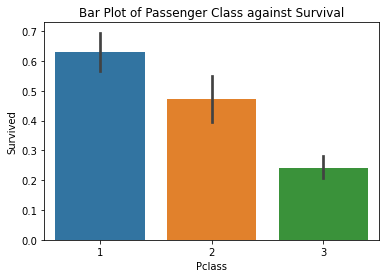

In [28]:
sns.barplot(x='Pclass', y='Survived', data=full_df)
plt.xlabel('Pclass')
plt.ylabel('Survived')
plt.title('Bar Plot of Passenger Class against Survival');

In [29]:
full_df['Pclass'].value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

Most of the passengers are in the third class, and that is the class with the lowest survival rate-- less than half the survival rate of the passengers in class 1. Next, I review how this looks for males versus females.

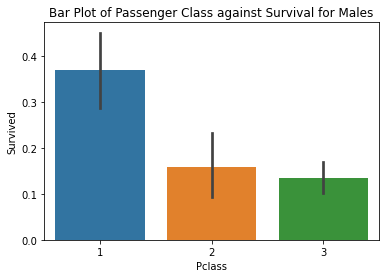

In [30]:
sns.barplot(x='Pclass', y='Survived', data=full_df[full_df['Sex']=='male'])
plt.xlabel('Pclass')
plt.ylabel('Survived')
plt.title('Bar Plot of Passenger Class against Survival for Males');

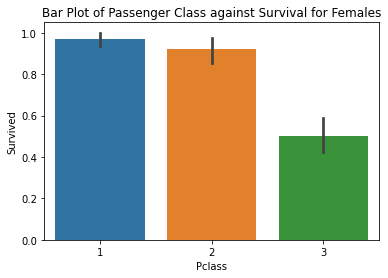

In [31]:
sns.barplot(x='Pclass', y='Survived', data=full_df[full_df['Sex']=='female'])
plt.xlabel('Pclass')
plt.ylabel('Survived')
plt.title('Bar Plot of Passenger Class against Survival for Females');

Interestingly, there is little difference between the survival rates of males in second and third class and in females in first and second class. I create a new feature to reflect these patterns.

In [32]:
full_df.loc[(full_df['Sex']=='male')&(full_df['Pclass']==1),'Class_Gender'] = 'First Class Male'
full_df.loc[(full_df['Sex']=='male')&(full_df['Pclass']==2)|(full_df['Pclass']==3),'Class_Gender'] = 'Second or Third Class Male'
full_df.loc[(full_df['Sex']=='female')&(full_df['Pclass']==1)|(full_df['Pclass']==2),'Class_Gender'] = 'First or Second Class Female'
full_df.loc[(full_df['Sex']=='female')&(full_df['Pclass']==3),'Class_Gender'] = 'Third Class Female'

In [34]:
full_df['Class_Gender'].value_counts()

Second or Third Class Male      493
First or Second Class Female    421
Third Class Female              216
First Class Male                179
Name: Class_Gender, dtype: int64

Next, I look at the correlation between sex and survival rate.

### 3b. Sex

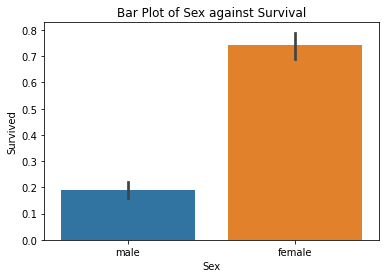

In [35]:
sns.barplot(x='Sex', y='Survived', data=full_df)
plt.xlabel('Sex')
plt.ylabel('Survived')
plt.title('Bar Plot of Sex against Survival');

In [37]:
full_df['Sex'].value_counts()

male      843
female    466
Name: Sex, dtype: int64

Males outnumber females almost 2 to 1, and the survival rate of males is substantially lower than the survival rate of females. There is a strong correlation between sex and surival rate.

### 2c. Age

To visualize passenger age, I bin the ages into ranges.

In [39]:
full_df['Age_Bins'] = pd.cut(full_df['Age'],bins=12)

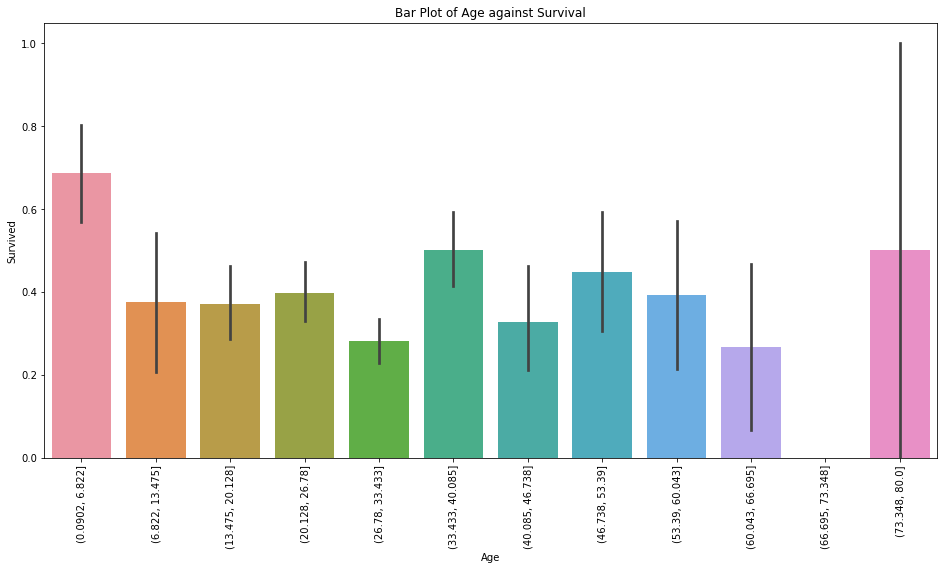

In [40]:
plt.figure(figsize=(16,8))
sns.barplot(x='Age_Bins', y='Survived', data=full_df)

plt.xlabel('Age')
plt.xticks(rotation='vertical')
plt.ylabel('Survived')
plt.title('Bar Plot of Age against Survival');

Children under the age of 7 had the strongest survival rates of any age group.

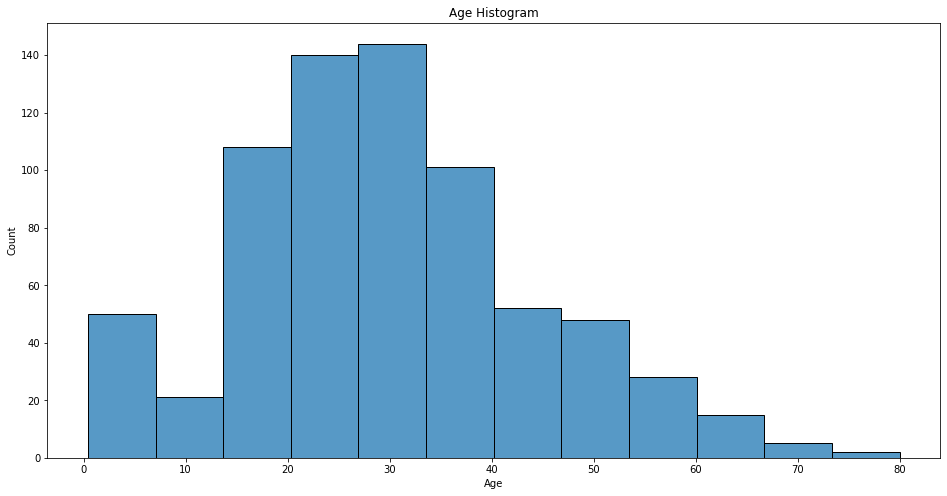

In [41]:
plt.figure(figsize=(16,8))
sns.histplot(x='Age',bins=12,data=train_df)
plt.title('Age Histogram');

Children below the age of 7 represented a small part of the data. I investigate further to see how age and sex relate.

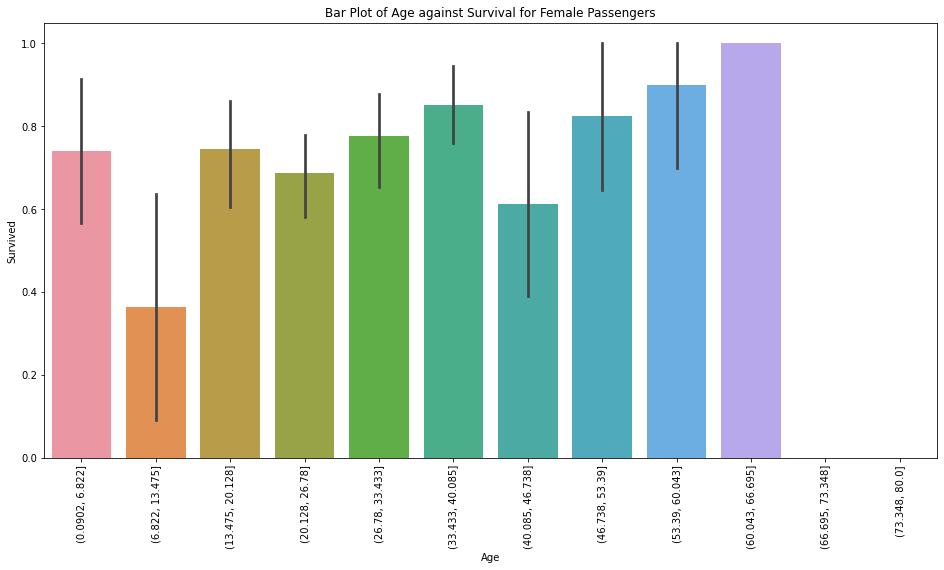

In [42]:
plt.figure(figsize=(16,8))
sns.barplot(x='Age_Bins', y='Survived', data=full_df[full_df['Sex']=='female'])

plt.xlabel('Age')
plt.xticks(rotation='vertical')
plt.ylabel('Survived')
plt.title('Bar Plot of Age against Survival for Female Passengers');

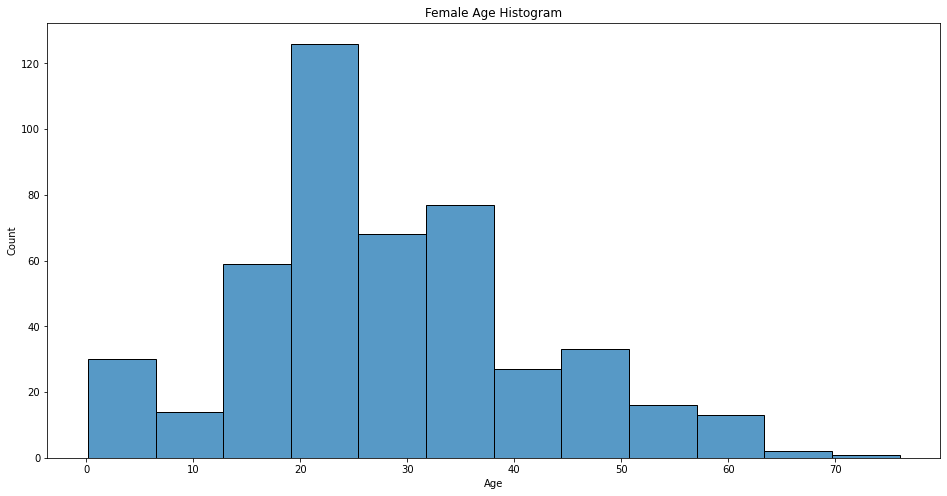

In [43]:
plt.figure(figsize=(16,8))
sns.histplot(x='Age',bins=12,data=full_df[full_df['Sex']=='female'])
plt.title('Female Age Histogram');

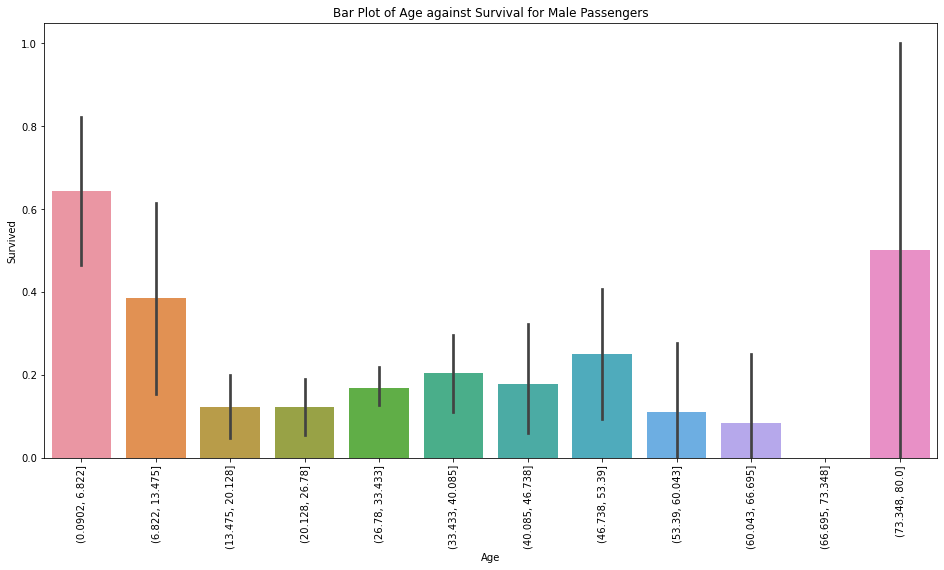

In [44]:
plt.figure(figsize=(16,8))
sns.barplot(x='Age_Bins', y='Survived', data=full_df[full_df['Sex']=='male'])

plt.xlabel('Age')
plt.xticks(rotation='vertical')
plt.ylabel('Survived')
plt.title('Bar Plot of Age against Survival for Male Passengers');

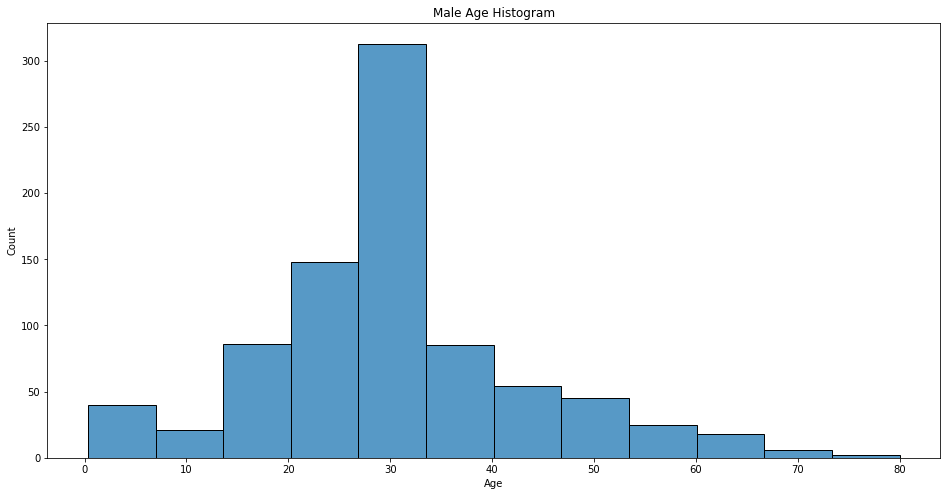

In [45]:
plt.figure(figsize=(16,8))
sns.histplot(x='Age',bins=12,data=full_df[full_df['Sex']=='male'])
plt.title('Male Age Histogram');

Age does not play a significant role for remale passengers. While there are some fluctuations in survival rate across age groups, it is likely due to sample size. Generally, across all age groups, the survival rate for females is above 70%. For males, age plays a substantial role. Children below the age of 13 had substantially higher survival rates than children above 13. The title feature should help the model to acknowledge this trend.

### 2d. Family

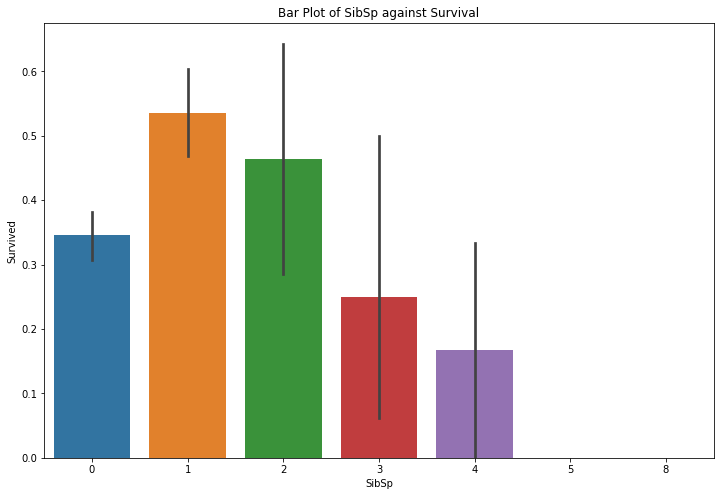

In [46]:
plt.figure(figsize=(12,8))
sns.barplot(x='SibSp', y='Survived', data=full_df)
plt.xlabel('SibSp')
plt.ylabel('Survived')
plt.title('Bar Plot of SibSp against Survival');

In [47]:
full_df['SibSp'].value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64

In [48]:
full_df[full_df['SibSp'] > 2].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,57.000000,46.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,514.964912,0.152174,2.842105,13.657895,4.385965,1.561404,52.755558
std,397.529422,0.363158,0.527442,10.061932,1.698259,0.598138,60.623453
min,8.000000,0.000000,1.000000,1.000000,3.000000,0.000000,7.775000
25%,172.000000,0.000000,3.000000,5.000000,3.000000,1.000000,27.900000
50%,410.000000,0.000000,3.000000,10.000000,4.000000,2.000000,31.387500
75%,825.000000,0.000000,3.000000,22.000000,5.000000,2.000000,46.900000
max,1286.000000,1.000000,3.000000,38.000000,8.000000,2.000000,263.000000


The SibSp category is difficult to parse because it combines siblings and spouses. There are only 46 records in the train data where the number is greater than 2, meaning there is at least one sibling involved (assuming each passenger has no more than 1 spouse).

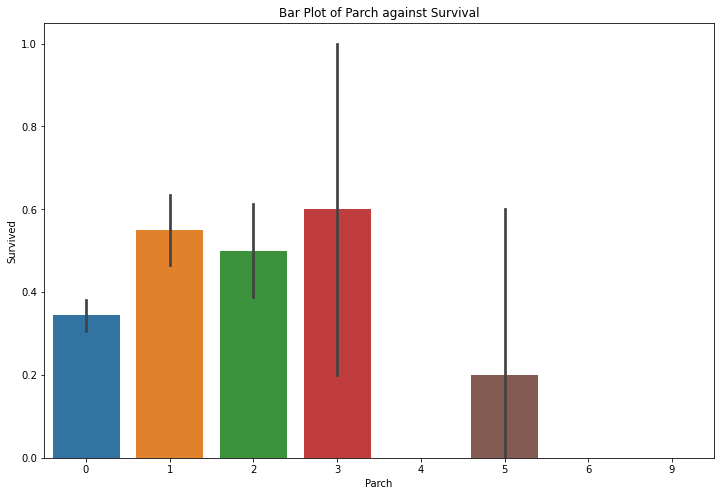

In [49]:
plt.figure(figsize=(12,8))
sns.barplot(x='Parch', y='Survived', data=full_df)
plt.xlabel('Parch')
plt.ylabel('Survived')
plt.title('Bar Plot of Parch against Survival');

In [50]:
full_df['Parch'].value_counts()

0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: Parch, dtype: int64

In [51]:
full_df[full_df['Parch']>2]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Title,Class_Gender,Age_Bins
13,14,0.0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,S,NaN,Mr,Second or Third Class Male,"(33.433, 40.085]"
25,26,1.0,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,S,NaN,Mrs,Third Class Female,"(33.433, 40.085]"
86,87,0.0,3,"Ford, Mr. William Neal",male,16.0,1,3,W./C. 6608,34.3750,S,NaN,Mr,Second or Third Class Male,"(13.475, 20.128]"
167,168,0.0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,S,NaN,Mrs,Third Class Female,"(40.085, 46.738]"
360,361,0.0,3,"Skoog, Mr. Wilhelm",male,40.0,1,4,347088,27.9000,S,NaN,Mr,Second or Third Class Male,"(33.433, 40.085]"
437,438,1.0,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24.0,2,3,29106,18.7500,S,NaN,Mrs,First or Second Class Female,"(20.128, 26.78]"
438,439,0.0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,S,C,Mr,First Class Male,"(60.043, 66.695]"
567,568,0.0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.0750,S,NaN,Mrs,Third Class Female,"(26.78, 33.433]"
610,611,0.0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,S,NaN,Mrs,Third Class Female,"(33.433, 40.085]"
638,639,0.0,3,"Panula, Mrs. Juha (Maria Emilia Ojala)",female,41.0,0,5,3101295,39.6875,S,NaN,Mrs,Third Class Female,"(40.085, 46.738]"


Once again, this category combines two types of information, so it is difficult to parse. To try to make the information easier to interpret, I create a family category that combines both values.

In [52]:
full_df['Family'] = full_df['SibSp'] + full_df['Parch']

In [53]:
full_df['Family'].value_counts()

0     790
1     235
2     159
3      43
5      25
4      22
6      16
10     11
7       8
Name: Family, dtype: int64

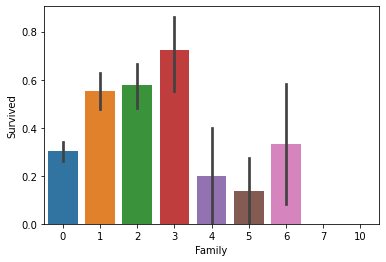

In [54]:
sns.barplot(x='Family', y='Survived', data=full_df);

Most of the passengers have zero family, and these passengers have a roughly average survival rate in the mid-thirties. Passengers with small families between 1 and 3 members also have similar survival rates that are above average. Passengers with large families have the lowest survival rates. I create new categories to reflect these trends.

In [55]:
full_df.loc[full_df['Family'] == 0,'Family_Grouped'] = 'None'
full_df.loc[(full_df['Family'] >= 1) & (full_df['Family'] <= 3),'Family_Grouped'] = 'Small'
full_df.loc[full_df['Family'] > 3,'Family_Grouped'] = 'Large'

In [56]:
full_df['Family_Grouped'].value_counts()

None     790
Small    437
Large     82
Name: Family_Grouped, dtype: int64

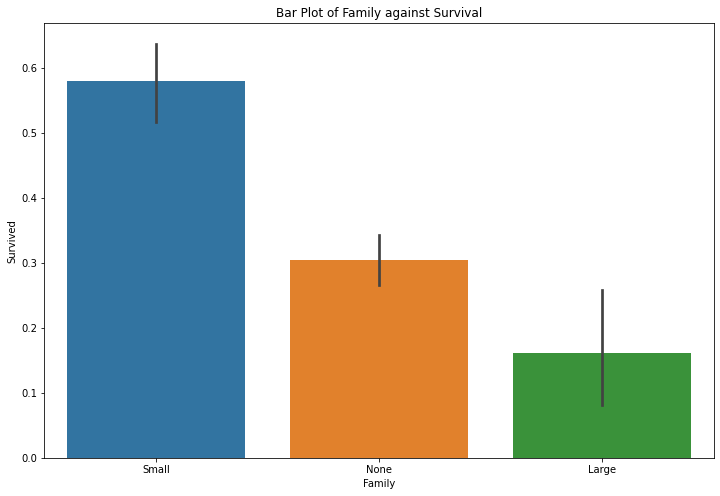

In [57]:
plt.figure(figsize=(12,8))
sns.barplot(x='Family_Grouped', y='Survived', data=full_df)
plt.xlabel('Family')
plt.ylabel('Survived')
plt.title('Bar Plot of Family against Survival');

I drop the family category because it is no longer necessary.

In [59]:
full_df.drop('Family', axis=1, inplace=True)

### 2e. Embarkment

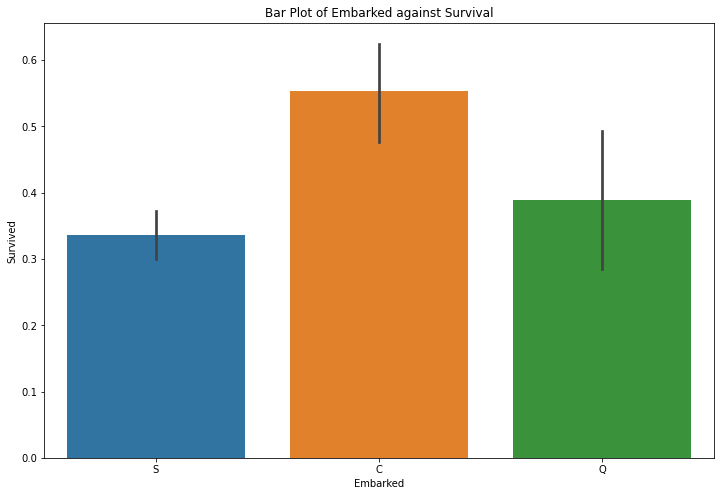

In [60]:
plt.figure(figsize=(12,8))
sns.barplot(x='Embarked', y='Survived', data=full_df)
plt.xlabel('Embarked')
plt.ylabel('Survived')
plt.title('Bar Plot of Embarked against Survival');

In [61]:
full_df['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

Most passengers embarked at Southampton. Passengers who embarked at Cherbourg had higher than average survival rates.

### 2f. Title

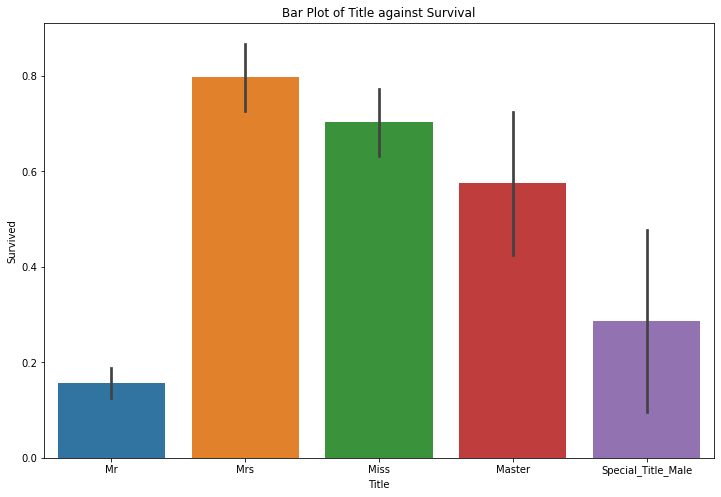

In [62]:
plt.figure(figsize=(12,8))
sns.barplot(x='Title', y='Survived', data=full_df)
plt.xlabel('Title')
plt.ylabel('Survived')
plt.title('Bar Plot of Title against Survival');

This reflects the trend from the analysis of age and gender. Adult males have the lowest survival rates; females have higher survival rates than male children.

### 2g. Fare

I start by making bins for the fares to make them easier to visualize and interpret.

In [63]:
full_df['Fare_Bins'] = pd.cut(full_df['Fare'],bins=25)

In [64]:
full_df['Fare_Bins'].value_counts()

(-0.512, 20.493]      758
(20.493, 40.986]      287
(40.986, 61.48]        83
(61.48, 81.973]        68
(81.973, 102.466]      28
(102.466, 122.959]     17
(245.918, 266.411]     16
(122.959, 143.452]     13
(204.932, 225.425]     13
(143.452, 163.945]     12
(225.425, 245.918]      5
(163.945, 184.439]      4
(491.836, 512.329]      4
(471.343, 491.836]      0
(266.411, 286.904]      0
(184.439, 204.932]      0
(327.891, 348.384]      0
(286.904, 307.398]      0
(307.398, 327.891]      0
(368.877, 389.37]       0
(389.37, 409.863]       0
(409.863, 430.357]      0
(430.357, 450.85]       0
(450.85, 471.343]       0
(348.384, 368.877]      0
Name: Fare_Bins, dtype: int64

By far the most common ticket fares were those under $20, and the next most common were those under $40. To see in more details, I create a histogram with 100 bins.

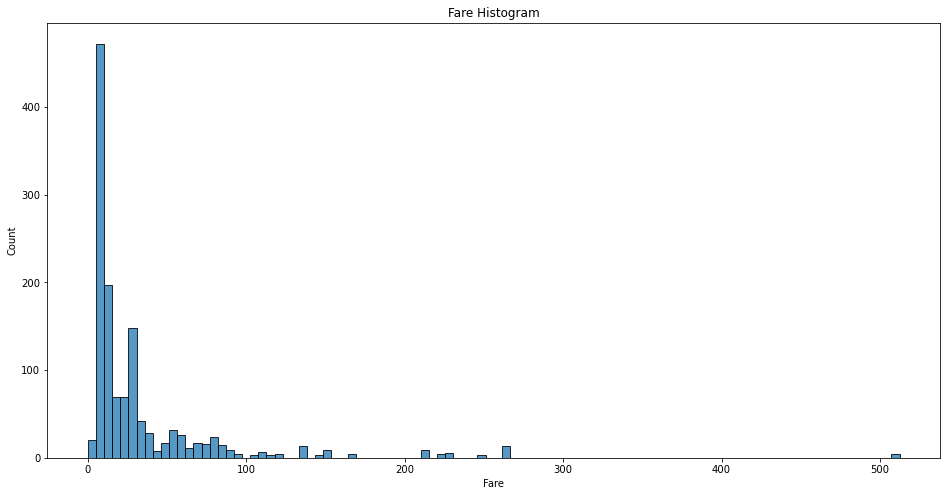

In [68]:
plt.figure(figsize=(16,8))
sns.histplot(x='Fare',bins=100,data=full_df)
plt.title('Fare Histogram');

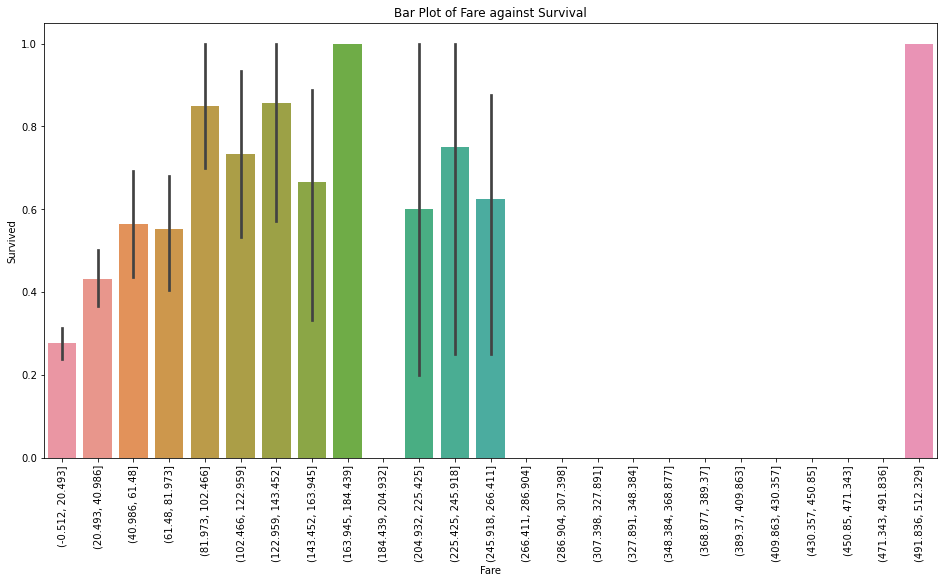

In [81]:
plt.figure(figsize=(16,8))
sns.barplot(x='Fare_Bins', y='Survived', data=full_df)

plt.xlabel('Fare')
plt.xticks(rotation='vertical')
plt.ylabel('Survived')
plt.title('Bar Plot of Fare against Survival');

Passengers with fares below $20 have the lowest survival rates and survival rates generally increase along with fare. To find the best way to group fares, I use .describe() with various groups and determine the following demarcations.

In [70]:
full_df[full_df['Fare'] > 75].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,145.000000,97.000000,145.0,145.000000,145.000000,145.000000,145.000000
mean,671.441379,0.762887,1.0,37.264966,0.634483,0.627586,146.839253
std,372.193104,0.427522,0.0,15.054262,0.685300,0.897100,87.841260
min,28.000000,0.000000,1.0,0.920000,0.000000,0.000000,75.241700
25%,333.000000,1.000000,1.0,26.000000,0.000000,0.000000,82.266700
50%,660.000000,1.000000,1.0,36.000000,1.000000,0.000000,113.275000
75%,1006.000000,1.000000,1.0,49.000000,1.000000,1.000000,211.337500
max,1306.000000,1.000000,1.0,76.000000,3.000000,4.000000,512.329200


In [71]:
full_df[(full_df['Fare'] > 10) & (train_df['Fare'] < 75)].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000
mean,440.984716,0.438865,2.117904,29.120808,0.825328,0.591703,27.568850
std,260.667091,0.496791,0.773796,15.156216,1.389257,0.966222,15.881122
min,2.000000,0.000000,1.000000,0.670000,0.000000,0.000000,10.170800
25%,203.000000,0.000000,2.000000,21.000000,0.000000,0.000000,14.500000
50%,447.500000,0.000000,2.000000,29.000000,0.000000,0.000000,25.964600
75%,665.250000,1.000000,3.000000,36.375000,1.000000,1.000000,31.387500
max,890.000000,1.000000,3.000000,80.000000,8.000000,6.000000,73.500000


In [72]:
full_df[full_df['Fare'] < 10].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,491.000000,336.000000,491.000000,491.000000,491.000000,491.000000,491.000000
mean,653.393075,0.199405,2.953157,27.523931,0.083503,0.034623,7.570553
std,373.916331,0.400149,0.278196,8.713710,0.382197,0.223202,1.581767
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,344.500000,0.000000,3.000000,22.000000,0.000000,0.000000,7.535400
50%,662.000000,0.000000,3.000000,28.000000,0.000000,0.000000,7.795800
75%,976.500000,0.000000,3.000000,29.000000,0.000000,0.000000,8.050000
max,1308.000000,1.000000,3.000000,74.000000,4.000000,2.000000,9.845800


In [78]:
full_df.loc[full_df['Fare'] >= 75,'Fare_Level'] = 'High'
full_df.loc[(full_df['Fare'] > 10) & (full_df['Fare'] < 75), 'Fare_Level'] = 'Medium'
full_df.loc[full_df['Fare'] <= 10,'Fare_Level'] = 'Low'

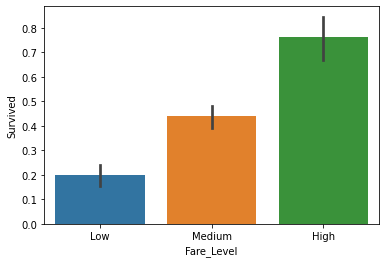

In [79]:
sns.barplot(x='Fare_Level', y='Survived', data=full_df);

In [80]:
full_df['Fare_Level'].value_counts()

Medium    672
Low       491
High      145
Name: Fare_Level, dtype: int64

There is no longer a need for the fare bins, so I drop them.

In [82]:
full_df.drop('Fare_Bins',axis=1,inplace=True)

## 4. Preparing for Modeling

Now I define the X and Y .

In [ ]:
X_train = train_df.drop(['Survived'], axis=1)
y_train = train_df['Survived']
X_test = test_df

Next, I define which columns need one hot encoding and which are already numerical.

In [ ]:
ohecols = ['Embarked','Title','Fare_Level','Family_Grouped','Class_Gender']

In [ ]:
numcols = ['Age','SibSp','Parch','Fare','Pclass']

In [ ]:
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [ ]:
ohe_sub = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', onehot)
])

In [ ]:
num_sub = Pipeline([
    ('cat_impute', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

In [ ]:
CT = ColumnTransformer(transformers=[
    ('onehot', ohe_sub, ohecols),
    ('numerical', num_sub, numcols)
])

In [ ]:
dum_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [ ]:
dum_pipe.fit(X_train, y_train)

In [ ]:
print(classification_report(y_train, dum_pipe.predict(X_train)))

## 4. Categorical Models

### 4a. Knn

In [ ]:
knn_pipe = Pipeline(steps=[
    ('ct', CT_ohe),
    ('Knn', KNeighborsClassifier())
])

In [ ]:
knn_pipe.fit(X_train, y_train)

In [ ]:
print(classification_report(y_train, knn_pipe.predict(X_train)))

###  4b. Random Forest

In [ ]:
rf_pipe = Pipeline([
    ('ct', CT_ohe),
    ('pf', PolynomialFeatures(degree = 2)),
    ('rf', RandomForestClassifier(max_depth=5))
])

In [ ]:
rf_pipe.fit(X_train,y_train)

In [ ]:
print(classification_report(y_train, rf_pipe.predict(X_train)))

In [ ]:
params_rf = {
    'rf__n_estimators' : [50,100,500],
    'rf__max_depth' : [3,5,7,10] 
}

In [ ]:
gs_rf = GridSearchCV(
    estimator = rf_pipe,
    param_grid = params_rf,
    cv = 5,
    verbose = 1)

In [ ]:
#gs_rf.fit(X_train,y_train)

In [ ]:
#gs_rf.best_params_

In [ ]:
rf_gs_pipe = Pipeline([
    ('ct', CT_ohe),
    ('pf', PolynomialFeatures(degree = 2)),
    ('rf', RandomForestClassifier(max_depth = 7, n_estimators = 50))
])

In [ ]:
rf_gs_pipe.fit(X_train,y_train)

In [ ]:
print(classification_report(y_train, rf_gs_pipe.predict(X_train)))

### 4c. ADA Boost

In [ ]:
ada_pipe = Pipeline([
    ('ct', CT_ohe),
    ('pf', PolynomialFeatures(degree = 2)),
    ('ada', AdaBoostClassifier())
])

In [ ]:
ada_pipe.fit(X_train,y_train)

In [ ]:
print(classification_report(y_train, ada_pipe.predict(X_train)))

### 4d. Gradient Boosting

In [ ]:
gb_pipe = Pipeline([
    ('ct', CT_ohe),
    ('pf', PolynomialFeatures(degree = 2)),
    ('gb', GradientBoostingClassifier())
])

In [ ]:
gb_pipe.fit(X_train,y_train)

In [ ]:
print(classification_report(y_train, gb_pipe.predict(X_train)))

### 4e. XGB

In [ ]:
xgb_pipe = Pipeline([
    ('ct', CT_ohe),
    ('pf', PolynomialFeatures(degree = 2)),
    ('xgb', XGBClassifier())
])

In [ ]:
xgb_pipe.fit(X_train,y_train)

In [ ]:
print(classification_report(y_train, xgb_pipe.predict(X_train)))

In [ ]:
params_xgb = {
    'xgb__n_estimators' : [50, 100, 200, 500],
    'xgb__max_depth' : [3, 5, 7, 10],
    'xgb__learning_rate' : [.01,.1,.3],
    'xgb__subsample' : [.5,.7,.9],
    'xgb__colsample_bytree' : [.5,.7,.9],
    'xgb__reg_alpha' : [0,.01,.1,1,10]
}

In [ ]:
gs_xgb = GridSearchCV(
    estimator = xgb_pipe,
    param_grid = params_xgb,
    cv = 5,
    verbose = 1
)

In [ ]:
#gs_xgb.fit(X_train,y_train)

In [ ]:
#gs_xgb.best_params_

In [ ]:
xgb_gs_pipe = Pipeline([
    ('ct', CT_ohe),
    ('pf', PolynomialFeatures(degree = 2)),
    ('xgb', XGBClassifier(colsample_bytree=.9,
                          learning_rate=.1,
                          max_depth=3,
                          n_estimators=100,
                          reg_alpha=0,
                          subsample=.7)
    )
])

In [ ]:
xgb_gs_pipe.fit(X_train,y_train)

In [ ]:
print(classification_report(y_train, xgb_gs_pipe.predict(X_train)))

### 4f. Multinomial Bayes

In [ ]:
mnb_pipe = Pipeline([
    ('ct', CT_ohe),
    ('mnb', MultinomialNB())
])

In [ ]:
mnb_pipe.fit(X_train,y_train)

In [ ]:
print(classification_report(y_train, mnb_pipe.predict(X_train)))

## 5. Modeling Numeric Categories

### 5a. Logistic Regression

In [ ]:
lr_pipe = Pipeline(steps=[
    ('ct', CT_num),
    ('lr', LogisticRegression(max_iter=1000))
])

In [ ]:
lr_pipe.fit(X_train, y_train)

In [ ]:
print(classification_report(y_train, lr_pipe.predict(X_train)))

In [ ]:
params = {
    'fsm__max_iter' : [10, 100, 1000, 10000],
    'fsm__C' : [0.0001, 0.001, 0.01, 0.1, 1],
    'fsm__tol' : [0.0001,0.001,0.01,0.1],
    'fsm__penalty' : ['l2','none'],
    'fsm__class_weight' : [None,'balanced']
}

In [ ]:
gs = GridSearchCV(
    estimator = lr_pipe,
    param_grid = params,
    cv = 5,
    verbose = 1
)

In [ ]:
#gs.fit(X,y)

In [ ]:
#gs.best_params_

In [ ]:
lr_gs_pipe = Pipeline(steps=[
    ('ct', CT_num),
    ('lr', LogisticRegression(C = .1,
                               class_weight = None,
                               max_iter=100,
                               penalty = 'l2',
                               tol = .0001))
])

In [ ]:
lr_gs_pipe.fit(X_train,y_train)

In [ ]:
print(classification_report(y_train, lr_gs_pipe.predict(X_train)))

In [ ]:
lr_pf_pipe = Pipeline(steps=[
    ('ct', CT_num),
    ('pf', PolynomialFeatures(degree = 3)),
    ('lr', LogisticRegression(C = .1,
                               class_weight = None,
                               max_iter=100,
                               penalty = 'l2',
                               tol = .0001))
])

In [ ]:
lr_pf_pipe.fit(X_train,y_train)

In [ ]:
print(classification_report(y_train, lr_pf_pipe.predict(X_train)))

### 5b. SVC

In [ ]:
svc_pipe = Pipeline(steps=[
    ('ct', CT_num),
    ('svc', SVC())
])

In [ ]:
svc_pipe.fit(X_train,y_train)

In [ ]:
print(classification_report(y_train, svc_pipe.predict(X_train)))

In [ ]:
params = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['rbf', 'poly', 'sigmoid'],
    'svc__gamma': ['scale', 'auto']
}

In [ ]:
gs_svc = GridSearchCV(
    estimator = svc_pipe,
    param_grid = params,
    cv = 5,
    verbose = 1
)

In [ ]:
#gs_svc.fit(X_train,y_train)

In [ ]:
#gs_svc.best_params_

Same as defaults: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

## 6. Meta Classifiers

### 6a. Stacking Classifier

In [ ]:
estimator_list = [
    ('knn',knn_pipe),
    ('rf',rf_gs_pipe),
    ('ada',ada_pipe),
    ('xgb',xgb_gs_pipe),
    ('lr',lr_pf_pipe),
    ('svc',svc_pipe)
]

In [ ]:
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression(penalty='l2')
)

In [ ]:
stack_model.fit(X_train,y_train)

In [ ]:
print(classification_report(y_train, stack_model.predict(X_train)))

### 6b. Voting Classifier

In [ ]:
voting_model = VotingClassifier(
    estimators=estimator_list
)

In [ ]:
voting_model.fit(X_train,y_train)

In [ ]:
print(classification_report(y_train, voting_model.predict(X_train)))

## 7. Submission

In [ ]:
passenger_ids = X_test['PassengerId']

In [ ]:
predictions = voting_model.predict(X_test)

In [ ]:
result_df = pd.DataFrame({'PassengerId':passenger_ids,'Survived':predictions})

In [ ]:
result_df.to_csv('titanic_submission_12.csv',index=False)